# Clustering Seed Dataset

Author: **Marcin Sikorski**<br>
Date: October, 2023

Performing basic clustering on a dataset using four different approaches. The dataset contains geometrical properties of kernels belonging to three different varieties of wheat.

**Data source & description:** [UCI Machine Learning](https://archive.ics.uci.edu/dataset/236/seeds)

**Table of Contents:**

0. Read Dataset From TXT File
1. Mini Batch K-Means Clustering
2. Hierarchical (Agglomerative) Clustering
3. GMM Clustering (Gaussian Mixture Model)
4. DBSCAN Clustering (Density-Based Spatial Clustering of Applications with Noise)
5. Performance Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### 0. Read Dataset From TXT File

In [2]:
header = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry_coef', 'groove', 'type']
filename = 'seeds_dataset.txt'

df = pd.read_csv('seeds_dataset.txt', header=None, sep='\t')
df.columns = header

df.head()

,area,perimeter,compactness,length,width,asymmetry_coef,groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [3]:
# display unique labels in target
df['type'].unique().tolist()

[1, 2, 3]

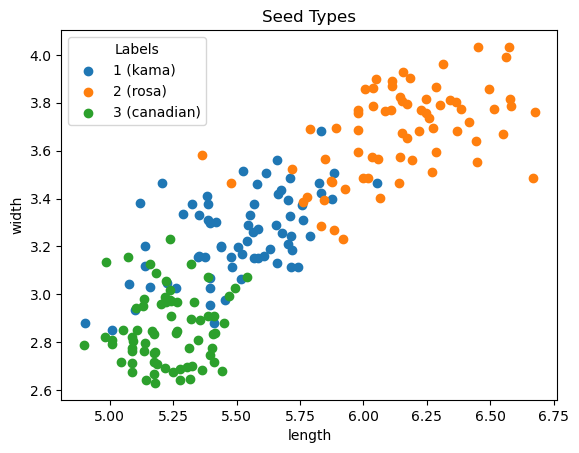

In [4]:
# seed types distribution
plt.scatter(x=df['length'][df['type'] == 1], y=df['width'][df['type'] == 1], label='1 (kama)')
plt.scatter(x=df['length'][df['type'] == 2], y=df['width'][df['type'] == 2], label='2 (rosa)')
plt.scatter(x=df['length'][df['type'] == 3], y=df['width'][df['type'] == 3], label='3 (canadian)')
plt.title('Seed Types')
plt.xlabel('length')
plt.ylabel('width')
plt.legend(title='Labels')
plt.show()

> We can spot some correlation between seed type and its basic dimensions.

### 1. Mini Batch K-Means Clustering

In [5]:
# X - feature array
# Y - target data
df_kmeans = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]]
Y = df['type']

#### I. Elbow Method

Determining the optimum number of clusters using the elbow plot method.

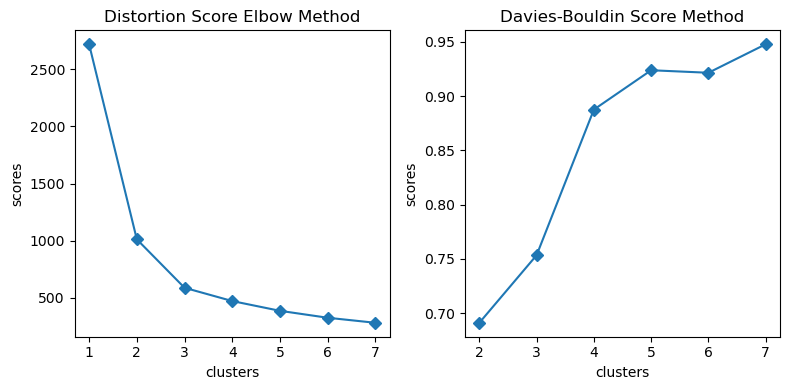

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# elbow method
inertias = [] 
for i in range(1, 8):
    if len(df_kmeans) >= i:
        kmeans = KMeans(n_clusters=i, max_iter=300)
        kmeans.fit(df_kmeans)
        inertias.append(kmeans.inertia_)
        
# Davies-Bouldin method
dav_bould_idx = []
for i in range(2, 8):
    if len(df_kmeans) >= i:
        kmeans = KMeans(n_clusters=i, max_iter=300)
        kmeans.fit(df_kmeans)
        cluster_labels = kmeans.labels_
        dav_bould_idx.append(davies_bouldin_score(df_kmeans, cluster_labels))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].plot(range(1, len(inertias)+1), inertias, marker='D')
axes[0].set(title='Distortion Score Elbow Method', xlabel='clusters', ylabel='scores')

axes[1].plot([*range(2, 8)], dav_bould_idx, marker='D')
axes[1].set(title='Davies-Bouldin Score Method', xlabel='clusters', ylabel='scores')

plt.tight_layout()
plt.show()

> The elbow plot indicates k = 3 to be the best choice. So, we will take 3 clusters.

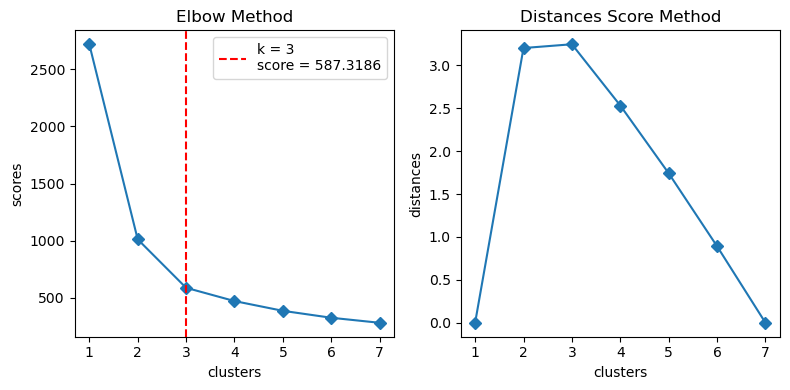

In [7]:
# alternatively, use inertias from elbow method to calculate the elbow point
# 1. fit a line between the maximum and the minimum point
# 2. calculate the distance between each point to this line - the point with the highest distance is the elbow point

from sklearn.linear_model import LinearRegression

x = [*range(1, 8)]
y = inertias

max_xx = np.max(x)
max_xy = y[np.argmax(x)]
max_yy = np.max(y)
max_yx = x[np.argmax(y)]
max_df = pd.DataFrame({'x': [max_yx, max_xx], 'y': [max_yy, max_xy]})

line_fit = LinearRegression().fit(max_df[['x']], max_df['y'])
iner_df = pd.DataFrame({'x': x, 'y': y})
distances = np.apply_along_axis(lambda this_point: np.abs(line_fit.coef_[0] * this_point[0] -
                                                         this_point[1] + line_fit.intercept_) /
                               np.sqrt(line_fit.coef_[0]**2 + 1), 1, iner_df)
k = x[np.argmax(distances)]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].plot(range(1, len(inertias)+1), inertias, marker='D')
axes[0].set(title='Elbow Method', xlabel='clusters', ylabel='scores')
axes[0].axvline(x=k, ls='--', color='red', label='k = {}\nscore = {:.4f}'.format(k, inertias[k-1]))
axes[0].legend()

axes[1].plot(range(1, len(inertias)+1), distances, marker='D')
axes[1].set(title='Distances Score Method', xlabel='clusters', ylabel='distances')

plt.tight_layout()
plt.show()

> Again, we proved 3 clusters to be the optimum choice. The distance for k = 3 is the longest.

#### II. Clustering

In [8]:
from sklearn.cluster import MiniBatchKMeans

cluster_kmeans = MiniBatchKMeans(n_clusters=3)
model_kmeans = cluster_kmeans.fit(df_kmeans)

# labels of each instance
pred_kmeans = model_kmeans.labels_
pred_kmeans

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2,
       2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
# get cluster centers for 'asymmetry_coef' & 'area'
centroids = cluster_kmeans.cluster_centers_
cen_x = [i[5] for i in centroids]
cen_y = [i[0] for i in centroids]

In [10]:
df_kmeans['cluster'] = pred_kmeans
df_kmeans['cen_x'] = df_kmeans['cluster'].map({0: cen_x[0], 1: cen_x[1], 2: cen_x[2]})
df_kmeans['cen_y'] = df_kmeans['cluster'].map({0: cen_y[0], 1: cen_y[1], 2: cen_y[2]})

# map color per cluster
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
df_kmeans['color'] = df_kmeans['cluster'].map({0: colors[0], 1: colors[1], 2: colors[2]})

df_kmeans.head()

,area,perimeter,compactness,length,width,asymmetry_coef,groove,cluster,cen_x,cen_y,color
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,2,2.933943,15.28702,#2ca02c
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,2,2.933943,15.28702,#2ca02c
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,2,2.933943,15.28702,#2ca02c
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,2,2.933943,15.28702,#2ca02c
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,2,2.933943,15.28702,#2ca02c


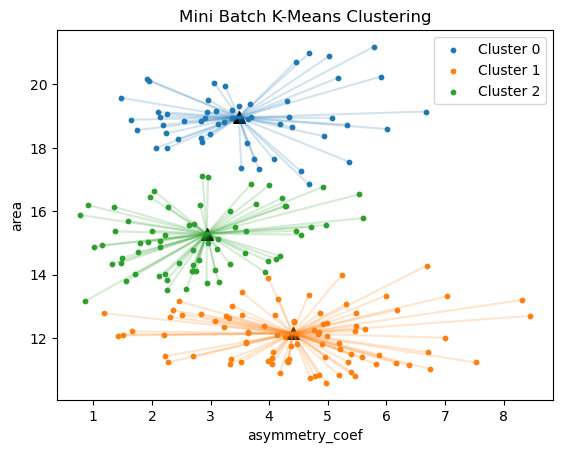

In [11]:
# visualize clustering
plt.scatter(x=df_kmeans['asymmetry_coef'][df_kmeans['cluster'] == 0], y=df_kmeans['area'][df_kmeans['cluster'] == 0],
            s=10, label='Cluster 0')
plt.scatter(x=df_kmeans['asymmetry_coef'][df_kmeans['cluster'] == 1], y=df_kmeans['area'][df_kmeans['cluster'] == 1],
            s=10, label='Cluster 1')
plt.scatter(x=df_kmeans['asymmetry_coef'][df_kmeans['cluster'] == 2], y=df_kmeans['area'][df_kmeans['cluster'] == 2],
            s=10, label='Cluster 2')

# plot lines
for idx, val in df_kmeans.iterrows():
    x = [val.asymmetry_coef, val.cen_x,]
    y = [val.area, val.cen_y]
    plt.plot(x, y, c=val.color, alpha=0.2)

# plot centroids
plt.scatter(cen_x, cen_y, marker='^', c='black', s=70)

plt.title('Mini Batch K-Means Clustering')
plt.xlabel('asymmetry_coef')
plt.ylabel('area')
plt.legend()
plt.show()

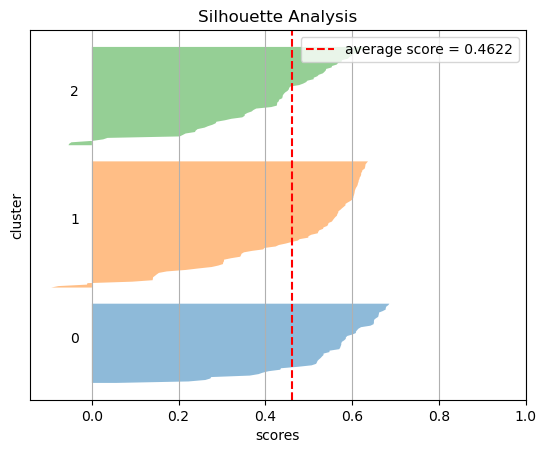

In [12]:
from sklearn.metrics import silhouette_score, silhouette_samples

X = df_kmeans.iloc[:, [0, 1, 2, 3, 4, 5, 6]]

# silhouette score for each sample
silhouette_vals = silhouette_samples(X, pred_kmeans)

y_lower = 0
y_upper = 0
for i in [0, 1, 2]:
    # group and sort silhouette scores
    cluster_silhouette_vals = silhouette_vals[pred_kmeans == i]
    cluster_silhouette_vals.sort()
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(y=np.arange(y_lower, y_upper), x1=0, x2=cluster_silhouette_vals, alpha=0.5, edgecolor=None)
    
    # cluster label at the middle
    plt.text(x=-0.05, y=(y_lower + y_upper) / 2, s=str(i))
    # new y_lower for next plot
    y_lower = y_upper + 10

# plot average silhouette scores
avg_score = (silhouette_vals).mean()
plt.axvline(x=avg_score, ls='--', color='red', label='average score = {:.4f}'.format(avg_score))
plt.yticks([])
plt.xlim([silhouette_vals.min() - 0.05, 1])
plt.title('Silhouette Analysis')
plt.xlabel('scores')
plt.ylabel('cluster')
plt.grid(axis='x')
plt.legend()
plt.show()

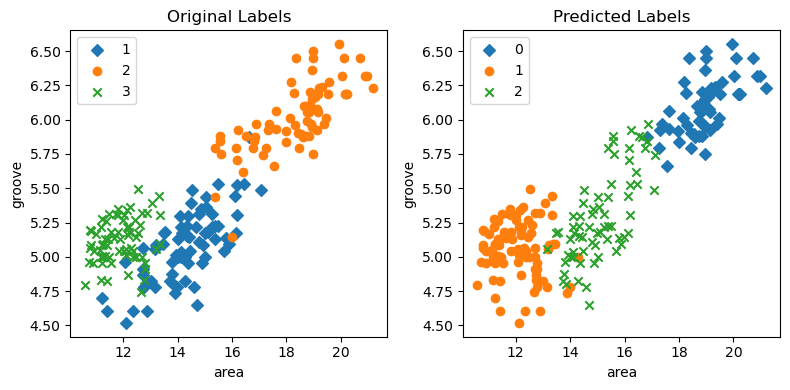

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].scatter(x=df['area'][df['type'] == 1], y=df['groove'][df['type'] == 1], marker='D', label='1')
axes[0].scatter(x=df['area'][df['type'] == 2], y=df['groove'][df['type'] == 2], label='2')
axes[0].scatter(x=df['area'][df['type'] == 3], y=df['groove'][df['type'] == 3], marker='x', label='3')
axes[0].set(title='Original Labels', xlabel='area', ylabel='groove')
axes[0].legend()

axes[1].scatter(x=df_kmeans['area'][df_kmeans['cluster'] == 0], y=df_kmeans['groove'][df_kmeans['cluster'] == 0],
                marker='D', label='0')
axes[1].scatter(x=df_kmeans['area'][df_kmeans['cluster'] == 1], y=df_kmeans['groove'][df_kmeans['cluster'] == 1], label='1')
axes[1].scatter(x=df_kmeans['area'][df_kmeans['cluster'] == 2], y=df_kmeans['groove'][df_kmeans['cluster'] == 2],
                marker='x', label='2')
axes[1].set(title='Predicted Labels', xlabel='area', ylabel='groove')
axes[1].legend()

plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import calinski_harabasz_score, rand_score, mutual_info_score, homogeneity_score, completeness_score

print('Original labels:')
print(df['type'].value_counts())
print('-' * 30)
print('Predicted labels:')
print(df_kmeans['cluster'].value_counts())

print('\nPerformance metrics:')
print('-' * 30)
print('Davies-Bouldin:', round(davies_bouldin_score(X, pred_kmeans), 4))
print('Caliński-Harabiasz:', round(calinski_harabasz_score(X, pred_kmeans), 4))
print('Adjusted Rand Index:', round(rand_score(Y, pred_kmeans), 4))
print('Adjusted Mutual Information:', round(mutual_info_score(Y, pred_kmeans), 4))
print('Homogeneity:', round(homogeneity_score(Y, pred_kmeans), 4))
print('Completness:', round(completeness_score(Y, pred_kmeans), 4))

Original labels:
1    70
2    70
3    70
Name: type, dtype: int64
------------------------------
Predicted labels:
1    87
2    68
0    55
Name: cluster, dtype: int64

Performance metrics:
------------------------------
Davies-Bouldin: 0.7664
Caliński-Harabiasz: 363.8429
Adjusted Rand Index: 0.8309
Adjusted Mutual Information: 0.7231
Homogeneity: 0.6582
Completness: 0.6689


### 2. Hierarchical (Agglomerative) Clustering

In [15]:
# X - feature array
# Y - target data
df_agglo = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]]
Y = df['type']

#### I. Dendrogram Method

Determining the optimum number of clusters using a dendrogram.

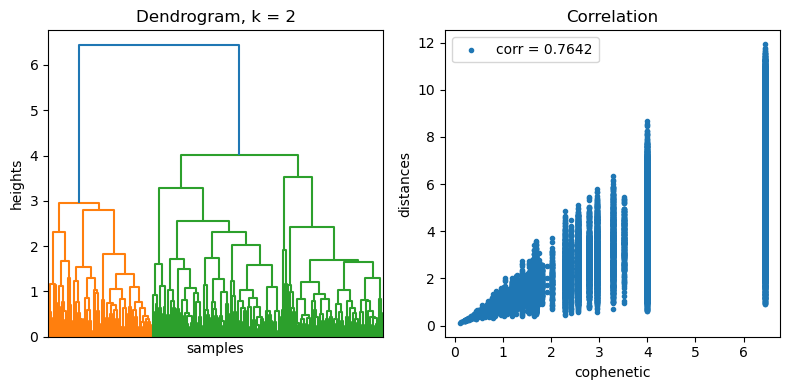

In [16]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, cophenet

dis_agglo = pdist(df_agglo)
Z = linkage(dis_agglo, method='average')

# number of flat clusters
num_clus = len(np.unique(fcluster(Z=Z, t=0.5*dis_agglo.max(), criterion='distance')))

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
dendrogram(Z)
plt.xticks([])
plt.title('Dendrogram, k = {}'.format(num_clus))
plt.xlabel('samples')
plt.ylabel('heights')

corr = np.corrcoef(x=cophenet(Z), y=dis_agglo)[0, 1]

plt.subplot(1, 2, 2)
plt.scatter(x=cophenet(Z), y=dis_agglo, marker='.', label='corr = {:.4}'.format(corr))
plt.title('Correlation')
plt.xlabel('cophenetic')
plt.ylabel('distances')
plt.legend()

plt.tight_layout()
plt.show()

> The dendrogram divided the data into 2 clusters but we can still spot 3 clear subtrees (cut line at height ~3.7). The correlation between extracted distances from hierarchical clustering and cophenetic distances suggest a good fit.

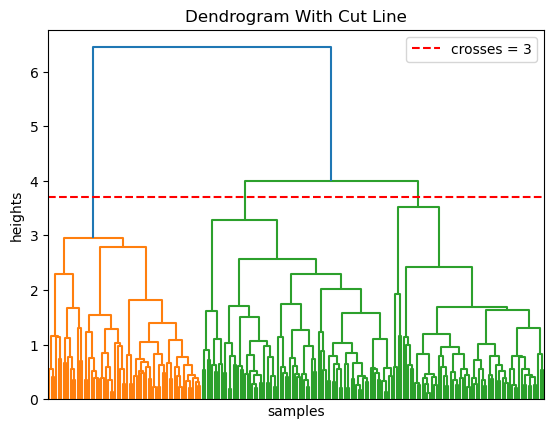

In [17]:
# count number of line crosses - horizontal cut line & tree lines
def number_clusters(height, Z):
    num_leaves = Z.shape[0] + 1
    merge_heights = Z[:, 2]
    num_clusters  = num_leaves - np.digitize(height, merge_heights)
    return num_clusters

height_ = 3.7
number_clusters(height=height_, Z=Z)

dendrogram(Z)
plt.xticks([])
plt.axhline(y=height_, ls='--', color='red', label='crosses = {}'.format(number_clusters(height=height_, Z=Z)))
plt.title('Dendrogram With Cut Line')
plt.xlabel('samples')
plt.ylabel('heights')
plt.legend()
plt.show()

#### II. PAC Bayesian generalization

Determining the optimum number of clusters with PAC Bayesian generalization.

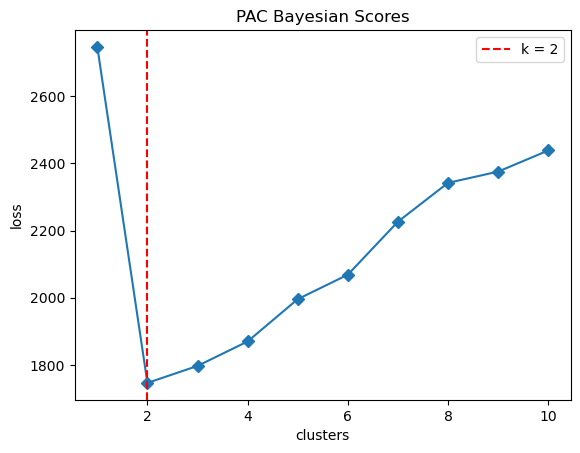

In [18]:
# description: https://towardsdatascience.com/automatic-dendrogram-cut-e019202e59a7

from dendrogram_cut import PACBayes
from scipy.spatial.distance import squareform

dis_agglo = pdist(df_agglo)
dis_square = squareform(dis_agglo)

model = PACBayes(k_max=10, method='average').fit(dis_square)
df_pac = model.pac_bayesian_cut(lambda_=0.2)

k = df_pac['loss'].idxmin() + 1

plt.plot(df_pac['k'], df_pac['loss'], marker='D')
plt.axvline(x=k, ls='--', color='red', label='k = {}'.format(k))
plt.title('PAC Bayesian Scores')
plt.xlabel('clusters')
plt.ylabel('loss')
plt.legend()
plt.show()

> The plot still suggests k = 2 just as in the tree diagram. We will still stay with 3 clusters.

#### III. Clustering

In [19]:
from sklearn.cluster import AgglomerativeClustering

cluster_agglo = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')  
model_agglo = cluster_agglo.fit(df_agglo)

# labels of each instance
pred_agglo = model_agglo.labels_
pred_agglo

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 2, 2, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [20]:
df_agglo['cluster'] = pred_agglo

# map color per cluster
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
df_agglo['color'] = df_agglo['cluster'].map({0: colors[0], 1: colors[1], 2: colors[2]})

df_agglo.head()

,area,perimeter,compactness,length,width,asymmetry_coef,groove,cluster,color
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,2,#2ca02c
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,2,#2ca02c
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,2,#2ca02c
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,2,#2ca02c
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,2,#2ca02c


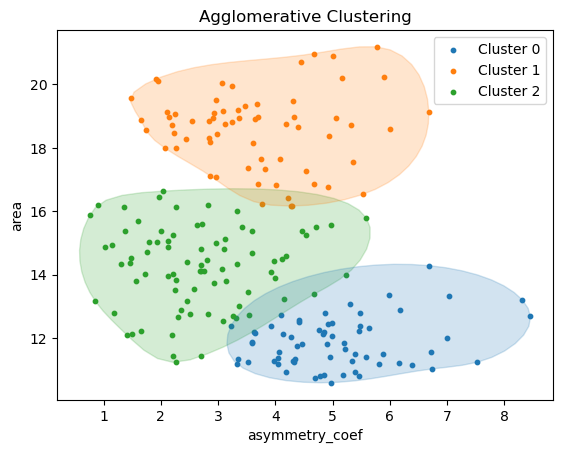

In [21]:
from scipy.spatial import ConvexHull
from scipy import interpolate

plt.scatter(x=df_agglo['asymmetry_coef'][df_agglo['cluster'] == 0], y=df_agglo['area'][df_agglo['cluster'] == 0], s=10, label='Cluster 0')
plt.scatter(x=df_agglo['asymmetry_coef'][df_agglo['cluster'] == 1], y=df_agglo['area'][df_agglo['cluster'] == 1], s=10, label='Cluster 1')
plt.scatter(x=df_agglo['asymmetry_coef'][df_agglo['cluster'] == 2], y=df_agglo['area'][df_agglo['cluster'] == 2], s=10, label='Cluster 2')

# plot boundaries
for i in df_agglo['cluster'].unique():
    # get the convex hull
    points = df_agglo[df_agglo['cluster'] == i][['asymmetry_coef', 'area']].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])
    
    # interpolate
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0, per=1)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)
    
    # plot shape
    plt.fill(interp_x, interp_y, '--', c=colors[i], alpha=0.2)

plt.title('Agglomerative Clustering')
plt.xlabel('asymmetry_coef')
plt.ylabel('area')
plt.legend()
plt.show()

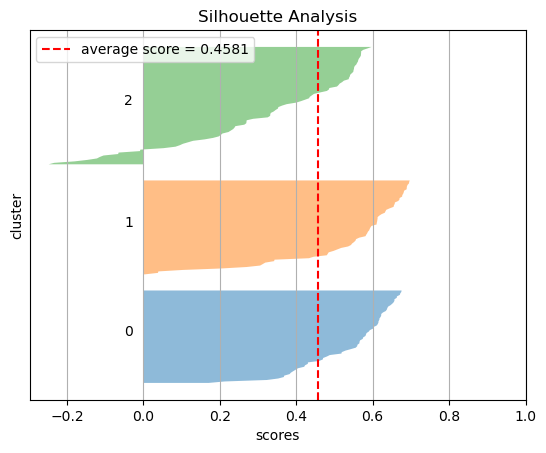

In [22]:
X = df_agglo.iloc[:, [0, 1, 2, 3, 4, 5, 6]]

# silhouette score for each sample
silhouette_vals = silhouette_samples(X, pred_agglo)

y_lower = 0
y_upper = 0
for i in [0, 1, 2]:
    # group and sort silhouette scores
    cluster_silhouette_vals = silhouette_vals[pred_agglo == i]
    cluster_silhouette_vals.sort()
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(y=np.arange(y_lower, y_upper), x1=0, x2=cluster_silhouette_vals, alpha=0.5, edgecolor=None)
    
    # cluster label at the middle
    plt.text(x=-0.05, y=(y_lower + y_upper) / 2, s=str(i))
    # new y_lower for next plot
    y_lower = y_upper + 10

# plot average silhouette scores
avg_score = (silhouette_vals).mean()
plt.axvline(x=avg_score, ls='--', color='red', label='average score = {:.4f}'.format(avg_score))
plt.yticks([])
plt.xlim([silhouette_vals.min() - 0.05, 1])
plt.title('Silhouette Analysis')
plt.xlabel('scores')
plt.ylabel('cluster')
plt.grid(axis='x')
plt.legend()
plt.show()

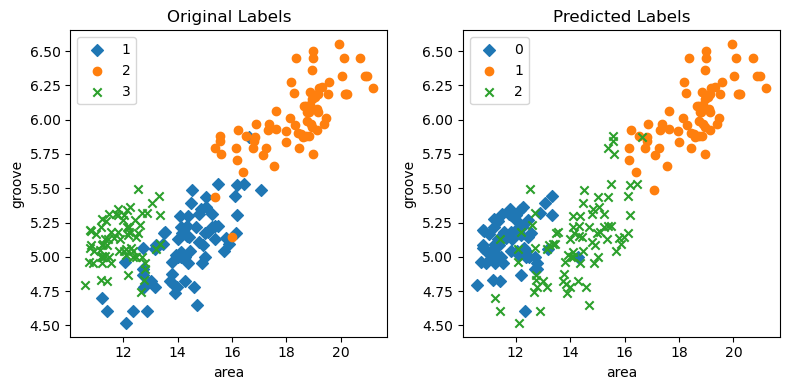

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].scatter(x=df['area'][df['type'] == 1], y=df['groove'][df['type'] == 1], marker='D', label='1')
axes[0].scatter(x=df['area'][df['type'] == 2], y=df['groove'][df['type'] == 2], label='2')
axes[0].scatter(x=df['area'][df['type'] == 3], y=df['groove'][df['type'] == 3], marker='x', label='3')
axes[0].set(title='Original Labels', xlabel='area', ylabel='groove')
axes[0].legend()

axes[1].scatter(x=df_agglo['area'][df_agglo['cluster'] == 0], y=df_agglo['groove'][df_agglo['cluster'] == 0], marker='D', label='0')
axes[1].scatter(x=df_agglo['area'][df_agglo['cluster'] == 1], y=df_agglo['groove'][df_agglo['cluster'] == 1], label='1')
axes[1].scatter(x=df_agglo['area'][df_agglo['cluster'] == 2], y=df_agglo['groove'][df_agglo['cluster'] == 2], marker='x', label='2')
axes[1].set(title='Predicted Labels', xlabel='area', ylabel='groove')
axes[1].legend()

plt.tight_layout()
plt.show()

In [24]:
print('Original labels:')
print(df['type'].value_counts())
print('-' * 30)
print('Predicted labels:')
print(df_agglo['cluster'].value_counts())

print('\nPerformance metrics:')
print('-' * 30)
print('Davies-Bouldin:', round(davies_bouldin_score(X, pred_agglo), 4))
print('Caliński-Harabiasz:', round(calinski_harabasz_score(X, pred_agglo), 4))
print('Adjusted Rand Index:', round(rand_score(Y, pred_agglo), 4))
print('Adjusted Mutual Information:', round(mutual_info_score(Y, pred_agglo), 4))
print('Homogeneity:', round(homogeneity_score(Y, pred_agglo), 4))
print('Completness:', round(completeness_score(Y, pred_agglo), 4))

Original labels:
1    70
2    70
3    70
Name: type, dtype: int64
------------------------------
Predicted labels:
2    81
1    65
0    64
Name: cluster, dtype: int64

Performance metrics:
------------------------------
Davies-Bouldin: 0.7604
Caliński-Harabiasz: 355.2366
Adjusted Rand Index: 0.8865
Adjusted Mutual Information: 0.7835
Homogeneity: 0.7131
Completness: 0.7171


### 3. GMM Clustering (Gaussian Mixture Model)

In [25]:
# X - feature array
# Y - target data
df_gmm = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]]
Y = df['type']

#### I. Bayesian Information Criterion (BIC) Function

Determining the optimal number of clusters using the BIC function.

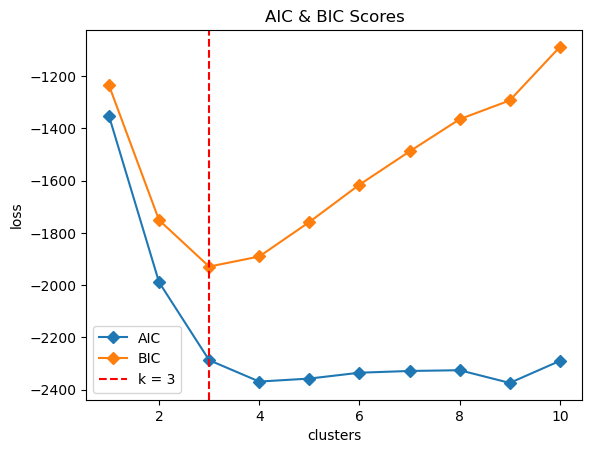

In [26]:
from sklearn.mixture import GaussianMixture

num_clusters = [*range(1, 11)]

# based on previous charts, 'full' or 'diag' covariance_type should be fine
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(df_gmm)
          for n in num_clusters]

bic_scores = [m.bic(df_gmm) for m in models]
k = bic_scores.index(min(bic_scores)) + 1

plt.plot(num_clusters, [m.aic(df_gmm) for m in models], marker='D', label='AIC')
plt.plot(num_clusters, [m.bic(df_gmm) for m in models], marker='D', label='BIC')
plt.axvline(x=k, ls='--', color='red', label='k = {}'.format(k))
plt.title('AIC & BIC Scores')
plt.xlabel('clusters')
plt.ylabel('loss')
plt.legend()
plt.show()

> In this case it is easy to detect the number of components. It appears that 3 clusters minimizes the penalty BIC.

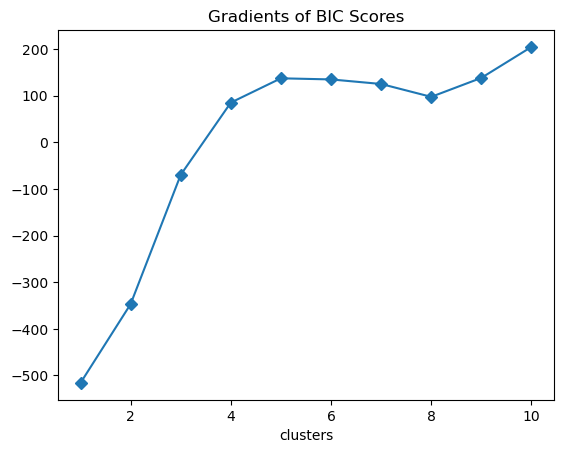

In [27]:
# plot gradients of BIC scores
plt.plot(num_clusters, np.gradient([m.bic(df_gmm) for m in models]), marker='D')
plt.title('Gradients of BIC Scores')
plt.xlabel('clusters')
plt.show()

> The negative values stop at k = 3. Starting from k = 4 the gradient becomes more constant, there is a gentle increase here as well as in the original BIC function. This plot also suggests 3 clusters to be optimal.

#### II. Distance Between GMMs

Determining the optimum number of clusters with Jensen-Shannon distances.

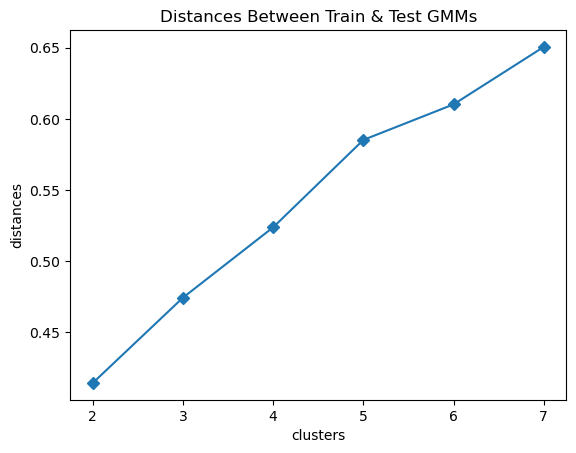

In [28]:
# source: https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms

from sklearn.model_selection import train_test_split

# return set of configurations with shorter distances
def select_best(arr, X):
    dx = np.argsort(arr)[:X]
    return arr[dx]

# convert dataframe into NumPy array
gmm_array = np.array(df_gmm)

# get Jensen-Shannon (JS) distance
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)
    js_metric = np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2)) + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

    return js_metric

num_clusters = [*range(2, 8)]
iterations = 20
results = []

for i in num_clusters:
    distances = []
    
    for iteration in range(iterations):
        # form two datasets, each with an half randomly choose amount of data
        train, test = train_test_split(gmm_array, test_size=0.5)
        
        gmm_train = GaussianMixture(i, n_init=2).fit(train) 
        gmm_test = GaussianMixture(i, n_init=2).fit(test) 
        distances.append(gmm_js(gmm_train, gmm_test))
        
    optimum = select_best(np.array(distances), int(iterations/5))
    result = np.mean(optimum)
    results.append(result)
    
plt.plot(num_clusters, results, marker='D')
plt.title('Distances Between Train & Test GMMs')
plt.xlabel('clusters')
plt.ylabel('distances')
plt.show()    

> The lower the Jensen-Shannon (JS) distance the better the cluster. This plot indicates 2 components to be the best.

#### III. Clustering

In [29]:
cluster_gmm = GaussianMixture(n_components=3, covariance_type='full')
model_gmm = cluster_gmm.fit(df_gmm)

# labels of each instance
pred_gmm = model_gmm.predict(df_gmm)
pred_gmm

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [30]:
# class probabilities for first 10 samples
prob_gmm = model_gmm.predict_proba(X)[:10, :]
np.around(prob_gmm, decimals=4)

array([[1.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00],
       [9.995e-01, 5.000e-04, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00],
       [9.952e-01, 0.000e+00, 4.800e-03],
       [1.000e+00, 0.000e+00, 0.000e+00]])

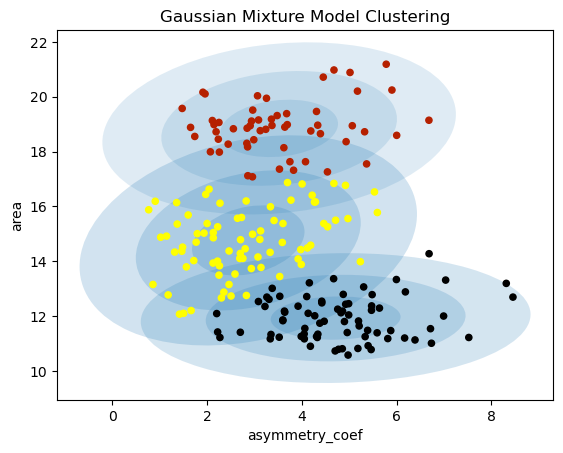

In [31]:
# source: https://michael-fuchs-python.netlify.app/2020/06/24/gaussian-mixture-models/

from matplotlib.patches import Ellipse

# plot an ellipse with given center and covariance
def plot_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
     
    # convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # plot the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

def plot_gmm(gmm, X, label=True):
    labels = gmm.fit(X).predict(X)
    if label:
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=20, zorder=2, cmap='gnuplot')
    else:
        plt.scatter(X[:, 0], X[:, 1], s=20, zorder=2)
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        plot_ellipse(pos, covar, alpha=w * w_factor)
        
    plt.title('Gaussian Mixture Model Clustering')
    plt.xlabel('asymmetry_coef')
    plt.ylabel('area')
    plt.show()
    
gmm = GaussianMixture(n_components=3, covariance_type='full')
X = np.array(df.iloc[:, [5, 0]])

plot_gmm(gmm, X)

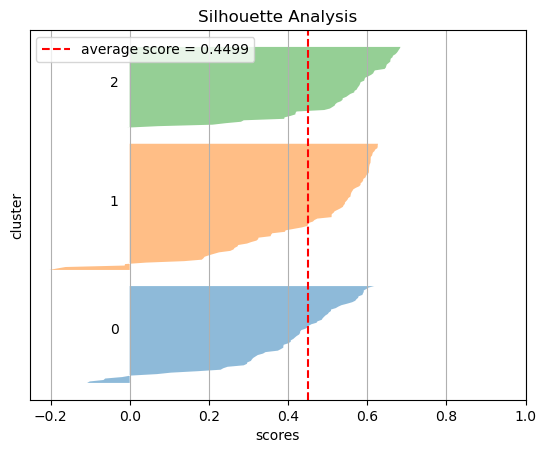

In [32]:
df_gmm['cluster'] = pred_gmm
X = df_gmm.iloc[:, [0, 1, 2, 3, 4, 5, 6]]

# silhouette score for each sample
silhouette_vals = silhouette_samples(X, pred_gmm)

y_lower = 0
y_upper = 0
for i in [0, 1, 2]:
    # group and sort silhouette scores
    cluster_silhouette_vals = silhouette_vals[pred_gmm == i]
    cluster_silhouette_vals.sort()
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(y=np.arange(y_lower, y_upper), x1=0, x2=cluster_silhouette_vals, alpha=0.5, edgecolor=None)
    
    # cluster label at the middle
    plt.text(x=-0.05, y=(y_lower + y_upper) / 2, s=str(i))
    # new y_lower for next plot
    y_lower = y_upper + 10

# plot average silhouette scores
avg_score = (silhouette_vals).mean()
plt.axvline(x=avg_score, ls='--', color='red', label='average score = {:.4f}'.format(avg_score))
plt.yticks([])
plt.xlim([silhouette_vals.min() - 0.05, 1])
plt.title('Silhouette Analysis')
plt.xlabel('scores')
plt.ylabel('cluster')
plt.grid(axis='x')
plt.legend()
plt.show()

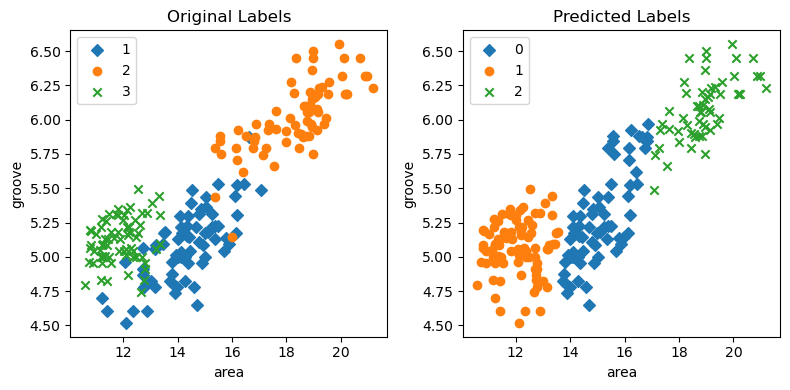

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].scatter(x=df['area'][df['type'] == 1], y=df['groove'][df['type'] == 1], marker='D', label='1')
axes[0].scatter(x=df['area'][df['type'] == 2], y=df['groove'][df['type'] == 2], label='2')
axes[0].scatter(x=df['area'][df['type'] == 3], y=df['groove'][df['type'] == 3], marker='x', label='3')
axes[0].set(title='Original Labels', xlabel='area', ylabel='groove')
axes[0].legend()

axes[1].scatter(x=df_gmm['area'][df_gmm['cluster'] == 0], y=df_gmm['groove'][df_gmm['cluster'] == 0], marker='D', label='0')
axes[1].scatter(x=df_gmm['area'][df_gmm['cluster'] == 1], y=df_gmm['groove'][df_gmm['cluster'] == 1], label='1')
axes[1].scatter(x=df_gmm['area'][df_gmm['cluster'] == 2], y=df_gmm['groove'][df_gmm['cluster'] == 2], marker='x', label='2')
axes[1].set(title='Predicted Labels', xlabel='area', ylabel='groove')
axes[1].legend()

plt.tight_layout()
plt.show()

In [34]:
print('Original labels:')
print(df['type'].value_counts())
print('-' * 30)
print('Predicted labels:')
print(df_gmm['cluster'].value_counts())

print('\nPerformance metrics:')
print('-' * 30)
print('Davies-Bouldin:', round(davies_bouldin_score(X, pred_gmm), 4))
print('Caliński-Harabiasz:', round(calinski_harabasz_score(X, pred_gmm), 4))
print('Adjusted Rand Index:', round(rand_score(Y, pred_gmm), 4))
print('Adjusted Mutual Information:', round(mutual_info_score(Y, pred_gmm), 4))
print('Homogeneity:', round(homogeneity_score(Y, pred_gmm), 4))
print('Completness:', round(completeness_score(Y, pred_gmm), 4))

Original labels:
1    70
2    70
3    70
Name: type, dtype: int64
------------------------------
Predicted labels:
1    87
0    67
2    56
Name: cluster, dtype: int64

Performance metrics:
------------------------------
Davies-Bouldin: 0.7958
Caliński-Harabiasz: 349.5519
Adjusted Rand Index: 0.8267
Adjusted Mutual Information: 0.7004
Homogeneity: 0.6376
Completness: 0.6473


### 4. DBSCAN Clustering (Density-Based Spatial Clustering of Applications with Noise)

Unlike previous methods, DBSCAN does not use the number of clusters as a hyperparameter. Instead, we need to find the optimal epsilon (maximum distance between two samples for one to be considered as in the neighborhood of the other) and minimum samples (number of samples in a neighborhood for a point to be considered as a core point). The features must also be standardized.

In [35]:
from sklearn.preprocessing import StandardScaler

X_ = np.array(df.iloc[:, [0, 1, 2, 3, 4, 5, 6]])

# X - feature array -- standardize the data (for early convergence of algorithm)
# Y - target data
df_scan = StandardScaler().fit_transform(X_)
Y = df['type']

#### I. Elbow Method

Determining the optimal hyperparameters using the elbow method - with kNN distance function.

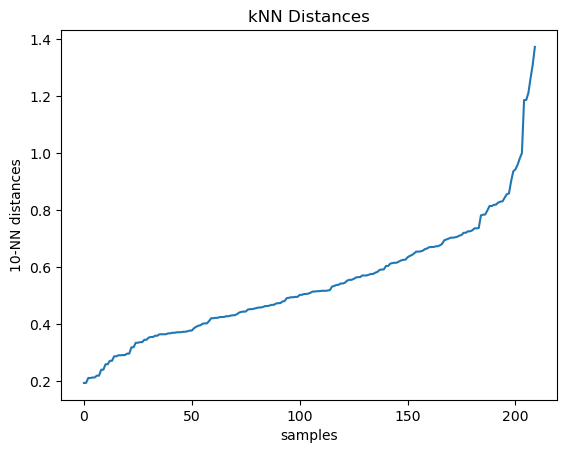

In [36]:
from sklearn.neighbors import NearestNeighbors

nn_neighbors = 10
nn_model = NearestNeighbors(n_neighbors=nn_neighbors).fit(df_scan)
distances_, indices = nn_model.kneighbors(df_scan)

distances = np.sort(distances_, axis=0)
nn_distances = distances[:, 1]

# elbow plot for optimal epsilon
plt.plot(nn_distances)
plt.title('kNN Distances')
plt.xlabel('samples')
plt.ylabel('{}-NN distances'.format(nn_neighbors))
plt.show()

> Based on this plot we will accept the epsilon range from 0.7 to 1.0 to determine the "knee" (optimum value). We will use a heuristic approach to get it.

In [37]:
from sklearn.cluster import DBSCAN

# epsilon & min. values to investigate
eps_values_ = np.arange(0.7, 1.0, 0.05)
eps_values = np.around(eps_values_, decimals=2)
min_samples = range(2, 21)

# list of DBSCAN parameters
dbscan_params = []
for eps_value in eps_values:
    for min_sample in min_samples:
        dbscan_params.append((eps_value, min_sample))


num_clusters = []
sil_score = []
for p in dbscan_params:
    dbs_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(df_scan)
    num_clusters.append(len(np.unique(dbs_clustering.labels_)))
    try:
        sil_score.append(silhouette_score(df_scan, dbs_clustering.labels_))
    except:
        sil_score.append(0.00)

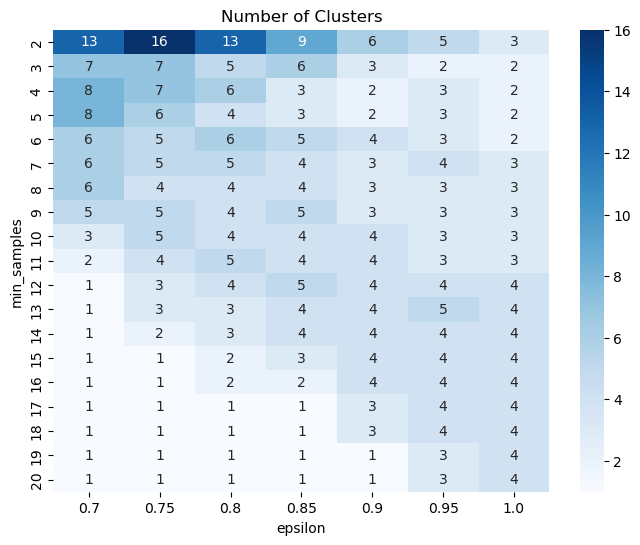

In [38]:
from seaborn import heatmap

tmp = pd.DataFrame.from_records(data=dbscan_params, columns=['epsilon', 'min_samples'])   
tmp['num_clusters'] = num_clusters
tmp['sil_score'] = sil_score

# pivot table containing number of clusters
pivot_clus = pd.pivot_table(tmp, values='num_clusters', index='min_samples', columns='epsilon')

plt.figure(figsize=(8, 6))
heatmap(pivot_clus, annot=True, cmap='Blues')
plt.title('Number of Clusters')
plt.show()

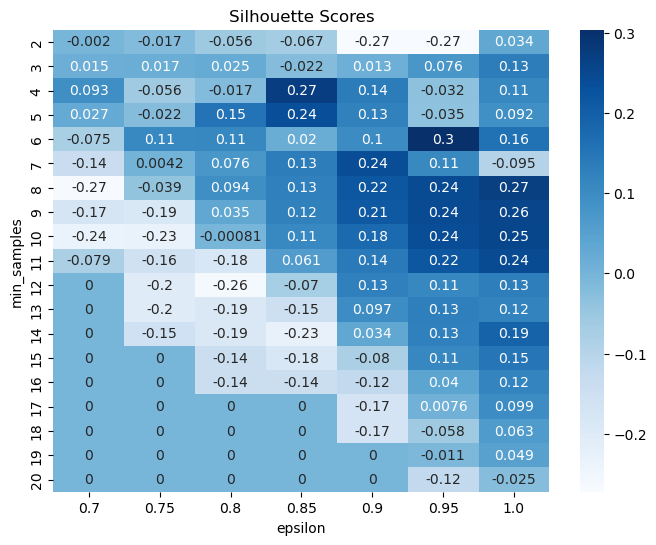

Optimum parameters:
epsilon = 0.95
minimum samples = 6


In [39]:
# pivot table containing silhouette scores
pivot_sil = pd.pivot_table(tmp, values='sil_score', index='min_samples', columns='epsilon')

plt.figure(figsize=(8, 6))
heatmap(pivot_sil, annot=True, cmap='Blues')
plt.title('Silhouette Scores')
plt.show()

print('Optimum parameters:\nepsilon = {:.2}\nminimum samples = {}'.format(pivot_sil.max(axis=0).idxmax(),
                                                                          pivot_sil.max(axis=1).idxmax()))

> The heatmap displays optimum score for epsilon 0.95 and minimum samples 6. This combination should return 3 clusters - based on previous heatmap.

#### II. Clustering

In [40]:
cluster_scan = DBSCAN(eps=0.95, min_samples=6)
model_scan = cluster_scan.fit(df_scan)

# labels of each instance
pred_scan = model_scan.labels_
pred_scan

array([ 0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0, -1, -1,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1, -1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  0,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  0,
        1, -1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0, -1,  0,  0], dtype=int64)

In [41]:
# display unique labels
np.unique(pred_scan).tolist()

[-1, 0, 1]

> The DBSCAN algorithm isolated three clusters as in previous methods. <code>-1</code> points are marked as noise.

In [42]:
df_dbscan = pd.DataFrame(df_scan)
df_dbscan.columns = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry_coef', 'groove']
df_dbscan['cluster'] = pred_scan

# map color per cluster
colors = ['red', '#1f77b4', '#ff7f0e']
df_dbscan['color'] = df_dbscan['cluster'].map({-1: colors[0], 0: colors[1], 1: colors[2]})

df_dbscan.head()

,area,perimeter,compactness,length,width,asymmetry_coef,groove,cluster,color
0,0.142098,0.215462,0.000061,0.304218,0.141702,-0.986152,-0.383577,0,#1f77b4
1,0.011188,0.008224,0.428515,-0.168625,0.197432,-1.788166,-0.922013,0,#1f77b4
2,-0.192067,-0.360201,1.442383,-0.763637,0.208048,-0.667479,-1.189192,0,#1f77b4
3,-0.347091,-0.475333,1.039381,-0.688978,0.319508,-0.960818,-1.229983,0,#1f77b4
4,0.445257,0.330595,1.374509,0.066666,0.805159,-1.563495,-0.475356,0,#1f77b4


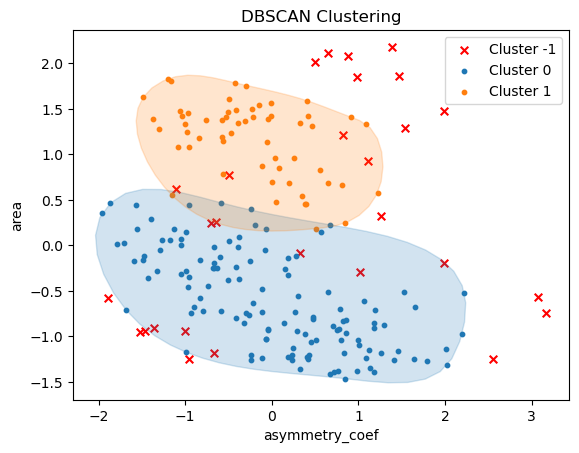

In [43]:
plt.scatter(x=df_dbscan['asymmetry_coef'][df_dbscan['cluster'] == -1], y=df_dbscan['area'][df_dbscan['cluster'] == -1],
            color='red', marker='x', s=30, label='Cluster -1')
plt.scatter(x=df_dbscan['asymmetry_coef'][df_dbscan['cluster'] == 0], y=df_dbscan['area'][df_dbscan['cluster'] == 0],
            s=10, label='Cluster 0')
plt.scatter(x=df_dbscan['asymmetry_coef'][df_dbscan['cluster'] == 1], y=df_dbscan['area'][df_dbscan['cluster'] == 1],
            s=10, label='Cluster 1')

# plot boundaries
for i in [0, 1]:
    # get the convex hull
    points = df_dbscan[df_dbscan['cluster'] == i][['asymmetry_coef', 'area']].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])
    
    # interpolate
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0, per=1)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)
    
    # plot shape
    plt.fill(interp_x, interp_y, '--', c=colors[i+1], alpha=0.2)

plt.title('DBSCAN Clustering')
plt.xlabel('asymmetry_coef')
plt.ylabel('area')
plt.legend()
plt.show()

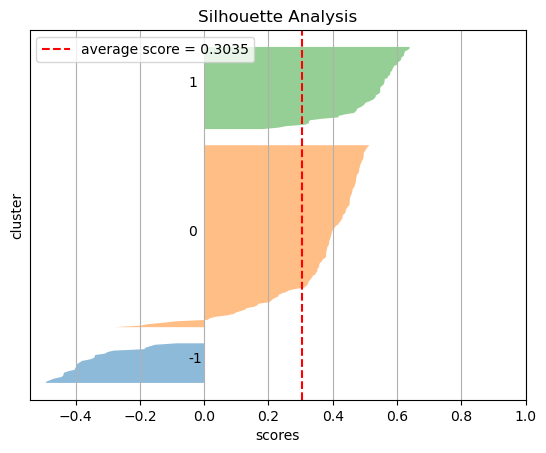

In [44]:
X = df_dbscan.iloc[:, [0, 1, 2, 3, 4, 5, 6]]

# silhouette score for each sample
silhouette_vals = silhouette_samples(X, pred_scan)

y_lower = 0
y_upper = 0
for i in [-1, 0, 1]:
    # group and sort silhouette scores
    cluster_silhouette_vals = silhouette_vals[pred_scan == i]
    cluster_silhouette_vals.sort()
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(y=np.arange(y_lower, y_upper), x1=0, x2=cluster_silhouette_vals, alpha=0.5, edgecolor=None)
    
    # cluster label at the middle
    plt.text(x=-0.05, y=(y_lower + y_upper) / 2, s=str(i))
    # new y_lower for next plot
    y_lower = y_upper + 10

# plot average silhouette scores
avg_score = (silhouette_vals).mean()
plt.axvline(x=avg_score, ls='--', color='red', label='average score = {:.4f}'.format(avg_score))
plt.yticks([])
plt.xlim([silhouette_vals.min() - 0.05, 1])
plt.title('Silhouette Analysis')
plt.xlabel('scores')
plt.ylabel('cluster')
plt.grid(axis='x')
plt.legend()
plt.show()

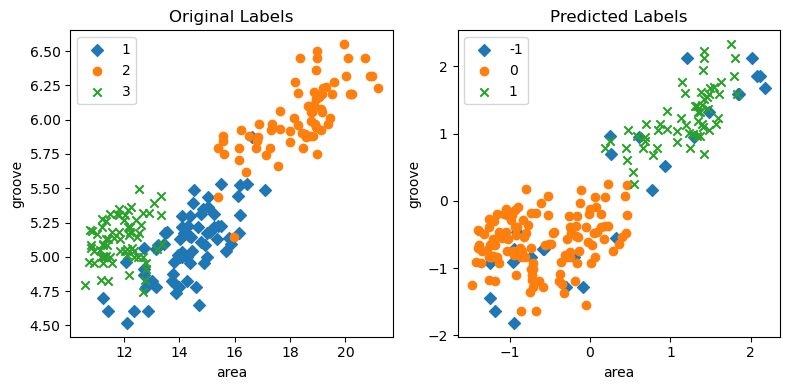

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].scatter(x=df['area'][df['type'] == 1], y=df['groove'][df['type'] == 1], marker='D', label='1')
axes[0].scatter(x=df['area'][df['type'] == 2], y=df['groove'][df['type'] == 2], label='2')
axes[0].scatter(x=df['area'][df['type'] == 3], y=df['groove'][df['type'] == 3], marker='x', label='3')
axes[0].set(title='Original Labels', xlabel='area', ylabel='groove')
axes[0].legend()

axes[1].scatter(x=df_dbscan['area'][df_dbscan['cluster'] == -1], y=df_dbscan['groove'][df_dbscan['cluster'] == -1],
                marker='D', label='-1')
axes[1].scatter(x=df_dbscan['area'][df_dbscan['cluster'] == 0], y=df_dbscan['groove'][df_dbscan['cluster'] == 0], label='0')
axes[1].scatter(x=df_dbscan['area'][df_dbscan['cluster'] == 1], y=df_dbscan['groove'][df_dbscan['cluster'] == 1], marker='x',
                label='1')
axes[1].set(title='Predicted Labels', xlabel='area', ylabel='groove')
axes[1].legend()

plt.tight_layout()
plt.show()

In [46]:
print('Original labels:')
print(df['type'].value_counts())
print('-' * 30)
print('Predicted labels:')
print(df_dbscan['cluster'].value_counts())

print('\nPerformance metrics:')
print('-' * 30)
print('Davies-Bouldin:', round(davies_bouldin_score(X, pred_scan), 4))
print('Caliński-Harabiasz:', round(calinski_harabasz_score(X, pred_scan), 4))
print('Adjusted Rand Index:', round(rand_score(Y, pred_scan), 4))
print('Adjusted Mutual Information:', round(mutual_info_score(Y, pred_scan), 4))
print('Homogeneity:', round(homogeneity_score(Y, pred_scan), 4))
print('Completness:', round(completeness_score(Y, pred_scan), 4))

Original labels:
1    70
2    70
3    70
Name: type, dtype: int64
------------------------------
Predicted labels:
 0    125
 1     57
-1     28
Name: cluster, dtype: int64

Performance metrics:
------------------------------
Davies-Bouldin: 2.1601
Caliński-Harabiasz: 84.9826
Adjusted Rand Index: 0.7193
Adjusted Mutual Information: 0.4824
Homogeneity: 0.4391
Completness: 0.5179


### 5. Performance Comparison

In [47]:
# metric lists
kmeans_scores = []
agglo_scores = []
gmm_scores = []
dbscan_scores = []

predictions = [pred_kmeans, pred_agglo, pred_gmm, pred_scan]
score_list = [kmeans_scores, agglo_scores, gmm_scores, dbscan_scores]

# create new list per algorithm
for pred, ls in zip(predictions, score_list):
    ls.append(silhouette_score(X, pred))
    ls.append(davies_bouldin_score(X, pred))
    ls.append(calinski_harabasz_score(X, pred))
    ls.append(rand_score(Y, pred))
    ls.append(mutual_info_score(Y, pred))
    ls.append(homogeneity_score(Y, pred))
    ls.append(completeness_score(Y, pred))
    
# validation scores in tabular form
metrics = pd.DataFrame.from_records(data=[kmeans_scores, agglo_scores, gmm_scores, dbscan_scores],
                    columns=['Silhouette', 'Davies-Bouldin', 'Caliński-Harabasz', 'ARI', 'AMI', 'Homogeneity', 'Completeness'],
                    index=['Mini Batch K-Means', 'Agglomerative', 'GMM', 'DBSCAN'])

# highlighting functions
def highlight_max(s):
    is_max = s == s.max()
    return ['background: gold' if cell else '' for cell in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['background: gold' if cell else '' for cell in is_min]

# highlight optimum scores
metric_ = metrics.style.apply(highlight_max,
                    subset=pd.IndexSlice[:, ['Silhouette', 'Caliński-Harabasz', 'ARI', 'AMI', 'Homogeneity', 'Completeness']])
metric_.apply(highlight_min, subset=pd.IndexSlice[:, ['Davies-Bouldin']])

,Silhouette,Davies-Bouldin,Caliński-Harabasz,ARI,AMI,Homogeneity,Completeness
Mini Batch K-Means,0.366105,0.985627,224.774362,0.830895,0.723112,0.658205,0.668874
Agglomerative,0.382757,0.960362,234.100200,0.886489,0.783452,0.713129,0.717076
GMM,0.357389,1.018277,219.749231,0.826703,0.700422,0.637551,0.647327
DBSCAN,0.303474,2.160062,84.982613,0.719344,0.482398,0.439097,0.517918


> Agglomerative clustering turned out to be the best choice of all approaches. All clustering algorithms worked fair enough with similar performances, instead of DBSCAN. This method would be more suitable for detecting outliers in datasets.